In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from fastai.vision import *

In [4]:
path = Path('../input/planet-understanding-the-amazon-from-space/')

In [5]:
df = pd.read_csv(path/'train_v2.csv'); df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [6]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [8]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [9]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

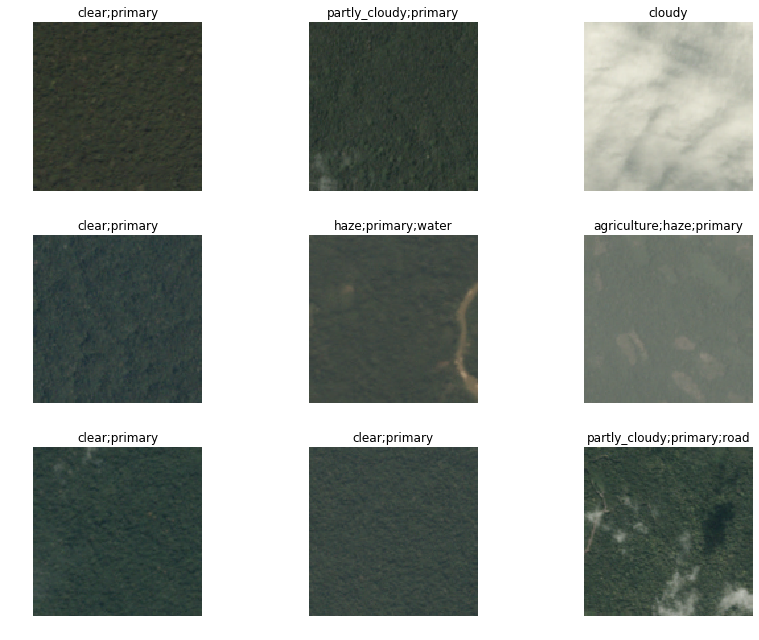

In [10]:
data.show_batch(3, figsize=(12, 9))

In [11]:
model = models.resnet50

In [12]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, model, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 89.0MB/s]


In [13]:
learn.model_dir = '/tmp/cache'
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


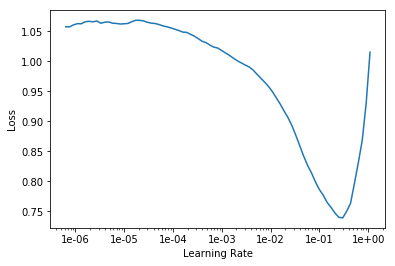

In [14]:
learn.recorder.plot()

In [15]:
lr = 0.01

In [16]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.134237,0.119417,0.949998,0.899384,03:28
1,0.111565,0.100360,0.954271,0.912262,03:01
2,0.100424,0.092685,0.952105,0.920681,03:00
3,0.097453,0.087664,0.955593,0.923956,02:58
4,0.094573,0.086682,0.956240,0.924481,03:00


In [17]:
learn.save('stage-1-rn50')

In [18]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


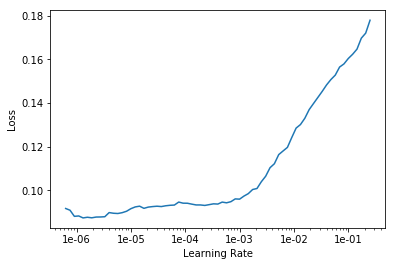

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 1e-2/2

In [21]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.109731,0.103943,0.948741,0.909126,03:05
1,0.109796,0.110336,0.941961,0.904602,03:04
2,0.100210,0.092680,0.954707,0.919524,03:04
3,0.091194,0.085017,0.954198,0.925320,03:04
4,0.085802,0.082863,0.958602,0.928851,03:03


In [22]:
learn.save('stage-2-rn50')

In [23]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [24]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


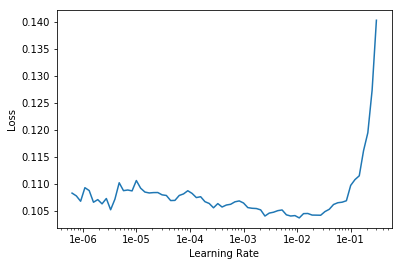

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
lr=1e-2/2
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.090912,0.087939,0.955317,0.922410,05:33
1,0.092409,0.087186,0.958616,0.922341,05:33
2,0.091413,0.084114,0.957810,0.927587,05:33
3,0.082625,0.082892,0.958362,0.928445,05:30
4,0.086439,0.082730,0.959648,0.929075,05:32


In [27]:
learn.save('stage-1-256-rn50')

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085907,0.082948,0.957970,0.927554,05:50
1,0.085432,0.082905,0.958718,0.928988,05:52
2,0.085024,0.082277,0.958166,0.930022,05:54
3,0.081407,0.081672,0.960440,0.930540,05:55
4,0.082163,0.081120,0.959706,0.930610,05:55


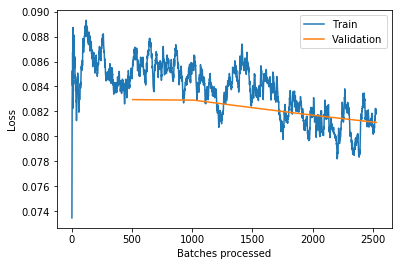

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.save('stage-2-256-rn50')

In [32]:
learn.export('/kaggle/working/export.pkl')

In [33]:
os.listdir('../input/planet-understanding-the-amazon-from-space/')

['train_v2.csv',
 'test-tif-v3',
 'train-tif-v2',
 'test-jpg-v2',
 'train-jpg',
 'test_v2_file_mapping.csv',
 'sample_submission_v2.csv']

In [34]:
test = ImageList.from_folder(path/'test-jpg-v2')
len(test)

61191

In [35]:
learn = load_learner('/kaggle/working/', test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [36]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [37]:
labelled_preds[:5]

['clear primary road water',
 'agriculture partly_cloudy primary road',
 'clear primary',
 'cloudy haze primary',
 'clear primary']

In [38]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
df.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 